# Multilayer Perceptron (MLP) From Scratch



In this section, we discuss the fundamental components of a feedforward neural network. Each component is derived mathematically and implemented explicitly using NumPy. No automatic differentiation or high-level abstractions are used; all gradients are computed manually to make the learning dynamics fully transparent.

We begin by defining a common interface for network layers, then implement linear transformations and nonlinear activation functions. Together, these components form the basis of forward propagation and backpropagation.
## Mathematical Equations, Computational Graphs, and Backpropagation

This notebook builds an MLP by defining **Layer** objects (Dense, ReLU, etc.) and composing them.

A layer maps:

$\mathbf{y} = f(\mathbf{x}; \theta)$

The MLP is a composition:

$f(\mathbf{x}) = f_L \circ f_{L-1} \circ \dots \circ f_1(\mathbf{x})$

Backpropagation is reverse-mode differentiation on the computational graph.

##  Dense (Fully Connected) Layer


If we use mini-batches.

- Batch size: (N)

- Input dimension: (d_{in})

- Hidden dimension: (d_h)

- Output classes: (C)

### Forward
For a batch input 
$\mathbf{x} \in \mathbb{R}^{N \times d_{in}}$:

$$\mathbf{y} = \mathbf{x}\mathbf{W} + \mathbf{b}$$

where:

- $\mathbf{W} \in \mathbb{R}^{d_{in} \times d_{out}}$
- $\mathbf{b} \in \mathbb{R}^{d_{out}}$
- $\mathbf{y} \in \mathbb{R}^{N \times d_{out}}$
---
### Computational graph (Dense)

```
x ──┐
    |
├── MatMul ── z ── Add ── y
    |               ▲
W ──┘               │
                    b
```

Mathematically:

$$ z = x W $$
$$ y = z + b $$

---

### Backward (gradients)
Assume upstream gradient:

$$\frac{\partial L}{\partial \mathbf{y}} = \mathbf{G}$$

Then:

$$\frac{\partial L}{\partial \mathbf{W}} = \mathbf{x}^T \mathbf{G}$$

$$\frac{\partial L}{\partial \mathbf{b}} = \sum_{n=1}^{N} \mathbf{G}_n$$

$$\frac{\partial L}{\partial \mathbf{x}} = \mathbf{G}\mathbf{W}^T$$


In [1]:
import numpy as np

class Layer:
    def forward(self, x, training=True):
        raise NotImplementedError

    def backward(self, grad_out):
        raise NotImplementedError

    def params(self):
        return []

    def grads(self):
        return []

    def zero_grads(self):
        pass


class Dense(Layer):
    def __init__(self, in_features, out_features, weight_scale=0.01):
        self.W = weight_scale * np.random.randn(in_features, out_features)
        self.b = np.zeros(out_features)
        self.x = None  # cache
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, x, training=True):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad_out):
        # grad_out = dL/dy
        self.dW = self.x.T @ grad_out           # dL/dW
        self.db = grad_out.sum(axis=0)          # dL/db
        grad_x = grad_out @ self.W.T            # dL/dx
        return grad_x

    def params(self):
        return [self.W, self.b]

    def grads(self):
        return [self.dW, self.db]

    def zero_grads(self):
        self.dW.fill(0.0)
        self.db.fill(0.0)


## 3. ReLU(Rectified Linear Unit) Activation

### Forward

- The ReLU function outputs 0 if the input is less than zero, otherwise it will return the input itself:
$$f(x) = \text{ReLU}(x) = \max(0,x) $$

- ReLU helps introduce non-linearity into the model, which is essential for learning complex patterns.
- It also helps avoid the vanishing gradient problem common in deep networks with the Sigmoid activation.
- During backpropagation, only the gradients for inputs greater than 0 pass through:

$$ f'(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{otherwise} \end{cases}$$


### Computational graph (Dense)

```
x ── ReLU ── y
    
```

### Backward
The derivative is:

$$\frac{d}{dx}\text{ReLU}(x) =
\begin{cases}
1 & x > 0 \\
0 & x \le 0
\end{cases}$$

So:

$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \odot \mathbb{1}_{x>0}$$


In [2]:
class ReLU(Layer):
    def __init__(self):
        self.mask = None

    def forward(self, x, training=True):
        self.mask = (x > 0)
        return np.maximum(0, x)

    def backward(self, grad_out):
        return grad_out * self.mask


## 4. Building an MLP by Composing Layers (Sequential)

If we build:

$$\mathbf{x} \rightarrow \text{Dense}_1 \rightarrow \text{ReLU} \rightarrow \text{Dense}_2 \rightarrow \text{ReLU} \rightarrow \text{Dense}_3 \rightarrow \mathbf{z}$$

Then the computational graph is:



In [3]:
class Sequential(Layer):
    def __init__(self, *layers):
        self.layers = list(layers)

    def forward(self, x, training=True):
        for layer in self.layers:
            x = layer.forward(x, training=training)
        return x

    def backward(self, grad_out):
        for layer in reversed(self.layers):
            grad_out = layer.backward(grad_out)
        return grad_out

    def params(self):
        ps = []
        for layer in self.layers:
            ps.extend(layer.params())
        return ps

    def grads(self):
        gs = []
        for layer in self.layers:
            gs.extend(layer.grads())
        return gs

    def zero_grads(self):
        for layer in self.layers:
            layer.zero_grads()


## 5. Softmax + Cross-Entropy Loss

### Softmax (probabilities)
Given logits 
$\mathbf{z} \in \mathbb{R}^{N \times C}$:
$$p_{n,i} = \frac{e^{z_{n,i}}}{\sum_{j=1}^{C} e^{z_{n,j}}}$$


### Cross-entropy (integer class labels)
If the true class for sample \(n\) is \(y_n\):

$$L = \frac{1}{N}\sum_{n=1}^{N} -\log(p_{n,y_n})$$


In [4]:
def softmax_cross_entropy_with_logits(logits, y):
    """
    logits: (N, C)
    y: (N,) integer labels
    returns: (loss, dlogits)
    """
    N, C = logits.shape

    # stable softmax
    z = logits - logits.max(axis=1, keepdims=True)
    exp_z = np.exp(z)
    probs = exp_z / exp_z.sum(axis=1, keepdims=True)

    # loss
    loss = -np.log(probs[np.arange(N), y] + 1e-12).mean()

    # gradient: (p - y_onehot)/N
    dlogits = probs.copy()
    dlogits[np.arange(N), y] -= 1.0
    dlogits /= N

    return loss, dlogits


def accuracy_from_logits(logits, y):
    pred = np.argmax(logits, axis=1)
    return (pred == y).mean()


## 6. Parameter Update (SGD)

Gradient descent update:

$$\theta \leftarrow \theta - \eta \frac{\partial L}{\partial \theta}$$

We apply this to each parameter tensor in the model.


In [5]:
class SGD:
    def __init__(self, lr=1e-2, weight_decay=0.0):
        self.lr = lr
        self.weight_decay = weight_decay

    def step(self, model):
        params = model.params()
        grads = model.grads()

        for p, g in zip(params, grads):
            if self.weight_decay != 0.0:
                g = g + self.weight_decay * p
            p -= self.lr * g


## 7. Toy Dataset (for demonstration)

We’ll generate a simple 2D classification dataset.

This is not about dataset quality—just to verify:
- forward works
- backward gradients propagate
- loss decreases during training


In [6]:
set_seed(0)

N = 400
X = np.random.randn(N, 2)

# non-linear target (quadrant-based)
y = (X[:, 0] * X[:, 1] > 0).astype(int)  # 0 or 1


NameError: name 'set_seed' is not defined

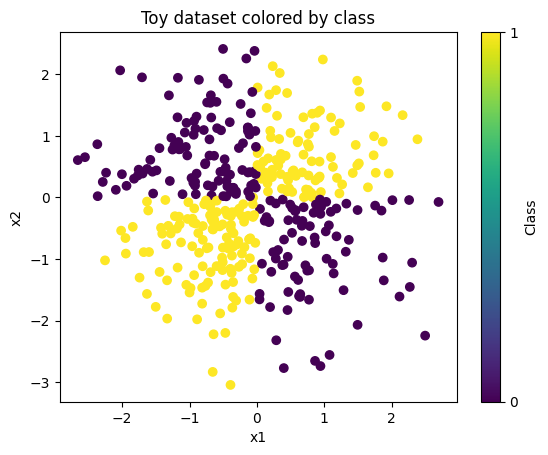

In [61]:
import matplotlib.pyplot as plt

# Assumes you already have:
# X: shape (N, 2)
# y: shape (N,) with values 0 or 1

X_plot = np.asarray(X)
y_plot = np.asarray(y).reshape(-1)

plt.figure()
sc = plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot)  # colors by class label
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Toy dataset colored by class")
plt.colorbar(sc, ticks=[0, 1], label="Class")
plt.show()


## 8. Build and Train the MLP

Model:

$$\mathbf{x} \rightarrow \text{Dense}(2, 64) \rightarrow \text{ReLU} \rightarrow \text{Dense}(64, 64) \rightarrow \text{ReLU} \rightarrow \text{Dense}(64, 2)$$

Training loop:
1. Forward: logits
2. Loss + gradient: $L, \frac{\partial L}{\partial \mathbf{z}}$
3. Backward through model
4. SGD update


In [63]:
set_seed(0)

model = Sequential(
    Dense(2, 64, weight_scale=0.1),
    ReLU(),
    Dense(64, 64, weight_scale=0.1),
    ReLU(),
    Dense(64, 2, weight_scale=0.1),
)

opt = SGD(lr=1e-2, weight_decay=1e-4)

for epoch in range(1, 301):
    # forward
    logits = model.forward(X, training=True)

    # loss + initial gradient
    loss, dlogits = softmax_cross_entropy_with_logits(logits, y)

    # backward
    model.zero_grads()
    model.backward(dlogits)

    # update
    opt.step(model)

    if epoch % 50 == 0:
        acc = accuracy_from_logits(model.forward(X, training=False), y)
        print(f"epoch={epoch:3d}  loss={loss:.4f}  acc={acc:.3f}")


epoch= 50  loss=0.6870  acc=0.655
epoch=100  loss=0.6803  acc=0.685
epoch=150  loss=0.6734  acc=0.685
epoch=200  loss=0.6651  acc=0.698
epoch=250  loss=0.6565  acc=0.710
epoch=300  loss=0.6478  acc=0.720


## 9. Student Checklist (Understanding Backprop)

Students should be able to explain:

1. Why Dense backward gives:
   $$\frac{\partial L}{\partial \mathbf{W}} = \mathbf{x}^T \frac{\partial L}{\partial \mathbf{y}}$$
2. Why ReLU backward uses a mask:
   
   $$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y}\odot \mathbb{1}_{x>0}$$
   
3. Why softmax + cross-entropy gradient simplifies to:
   
   $$\frac{\partial L}{\partial \mathbf{z}} = \frac{1}{N}(\mathbf{p}-\mathbf{Y})$$
   
4. How the computational graph explains the chain rule:
   
   $$\frac{\partial L}{\partial u} = \sum_{v} \frac{\partial L}{\partial v}\frac{\partial v}{\partial u}$$
   


# Backpropagation and Gradient Flow in a Multilayer Perceptron

This section provides a consolidated view of how gradients flow through the network,
from the loss function back to each layer’s parameters.

## Gradient Flow Diagram (Forward and Backward)

### Forward pass

```
                                        X (input batch)
                                           │
                                           ▼
                                        Dense1: Z1 = XW1 + b1
                                           │
                                           ▼
                                        ReLU1:  A1 = max(0, Z1)
                                           │
                                           ▼
                                        Dense2: Z2 = A1W2 + b2
                                           │
                                           ▼
                                        ReLU2:  A2 = max(0, Z2)
                                           │
                                           ▼
                                        Dense3: Z3 = A2W3 + b3   (logits)
                                           │
                                           ▼
                                        Softmax + Cross-Entropy Loss L
````

### Backward pass (reverse order)

```

                                        ∂L/∂Z3  (from loss)
                                           │
                                           ├── ∂L/∂W3 , ∂L/∂b3
                                           ▼
                                        ∂L/∂A2 = ∂L/∂Z3 · W3ᵀ
                                           │
                                           ▼
                                        ReLU mask (Z2 > 0)
                                           │
                                           ▼
                                        ∂L/∂Z2
                                           │
                                           ├── ∂L/∂W2 , ∂L/∂b2
                                           ▼
                                        ∂L/∂A1 = ∂L/∂Z2 · W2ᵀ
                                           │
                                           ▼
                                        ReLU mask (Z1 > 0)
                                           │
                                           ▼
                                        ∂L/∂Z1
                                           │
                                           ├── ∂L/∂W1 , ∂L/∂b1
                                           ▼
                                        ∂L/∂X

```

## Consolidated Backpropagation Mathematics

Consider a minibatch:
- Input: $ X \in \mathbb{R}^{N \times d_{in}} $
- Labels: $ y \in \{0,\dots,C-1\}^N $

The MLP is defined as:

$\begin{aligned}
Z_1 &= XW_1 + b_1 \\
A_1 &= \mathrm{ReLU}(Z_1) \\
Z_2 &= A_1W_2 + b_2 \\
A_2 &= \mathrm{ReLU}(Z_2) \\
Z_3 &= A_2W_3 + b_3
\end{aligned}$

### Step 1: Softmax + Cross-Entropy Gradient


$P = \mathrm{softmax}(Z_3)$


$L = -\frac{1}{N}\sum_{n=1}^N \log P_{n,y_n}$

The gradient with respect to logits is:


$\frac{\partial L}{\partial Z_3} = \frac{1}{N}(P - Y)$

This gradient is the **starting point of backpropagation**.

### Step 2: Dense Layer Backpropagation

For a dense layer:

$Z = AW + b$

Given upstream gradient $G = \frac{\partial L}{\partial Z} $:


$\begin{aligned}
\frac{\partial L}{\partial W} &= A^\top G \\
\frac{\partial L}{\partial b} &= \sum_{n=1}^N G_{n,:} \\
\frac{\partial L}{\partial A} &= G W^\top
\end{aligned}$

This applies to **all Dense layers** in the network.

### Step 3: ReLU Backpropagation

$A = \mathrm{ReLU}(Z)$

The derivative of ReLU is:

$\frac{\partial A}{\partial Z} =
\begin{cases}
1 & Z > 0 \\
0 & Z \le 0
\end{cases}$

Thus:
$\frac{\partial L}{\partial Z} =
\frac{\partial L}{\partial A} \odot \mathbf{1}[Z > 0]$

ReLU has **no parameters**, but it gates gradient flow.

## End-to-End Backpropagation Summary

- The loss function provides $ \frac{\partial L}{\partial Z_3} $
- Each Dense layer computes gradients for its **weights, bias, and inputs**
- Each ReLU layer applies a binary mask
- Gradients propagate backward via the chain rule
- The optimizer updates parameters using stored gradients

This mirrors exactly how the `backward()` methods are composed in the code.


